In [18]:
from sklearn.datasets import load_boston
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import time

from sklearn import datasets, linear_model
from sklearn import metrics, cross_validation
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [19]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [20]:
type(boston)

sklearn.datasets.base.Bunch

In [21]:
print(boston.DESCR)
print(boston.keys())
print(boston.feature_names)
print(boston.data.shape)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [22]:
X = boston.data

In [23]:
X[0:2, :]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00]])

In [24]:
y = boston.target

In [25]:
y[0:2]

array([ 24. ,  21.6])

## Prepare train/test sets

In [26]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.33, random_state = 5)

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (339, 13)
y_train shape: (339,)
X_test shape: (167, 13)
y_test shape: (167,)


## Define linear regression functions

In [27]:
def predict(X, theta):
    return X.dot(theta.T)

def sum_squared_error(y, y_pred):
    square_of_errors = np.square(y_pred - y)
    return np.sum(square_of_errors)

def mean_squared_error(y, y_pred):
    m = y.shape[0]
    return (1 / (m)) * sum_squared_error(y, y_pred)
    
def gradient(X, y, y_pred):
    m = X.shape[0]
    error = y_pred - y
    gradient = (1/m) * X.T.dot(error)
    return (gradient, error)
    
def gradient_descent(X_y_gen, theta, alpha, iterations):
    for it in range(iterations):
        for X, y in X_y_gen():
            m = X.shape[0]
            y_pred = predict(X, theta)
            grad, error = gradient(X, y, y_pred)
            theta = theta - (alpha * grad)
            
        log_gradient_descent_step(it, theta, error)
            
    return theta

def gradient_descent_stochastic(X_y_gen, theta, alpha, iterations):
    for it in range(iterations):
        for X, y in X_y_gen():
            for i, _ in enumerate(X):
                X_i = X[i]
                y_i = y[i]
                y_i_pred = predict(X_i, theta)
                grad, error = gradient(X_i, y_i, y_i_pred)
                theta = theta - (alpha * grad)

        log_gradient_descent_step(it, theta, error)
        
    return theta


def all_gen(X, y):
    def a():
        X_shuf, y_shuf = shuffle(X, y)
        yield (X_shuf, y_shuf)
    return a
        
def batch_gen(X, y, batch_size):
    def a():
        X_shuf, y_shuf = shuffle(X, y)
        for i in range(0, len(y_shuf), batch_size):
            yield (X_shuf[i:i+batch_size,:], y_shuf[i:i+batch_size])
    return a

## Define helper function

In [28]:
def plot_actual_over_predicted(y_actual, y_pred):
    plt.scatter(y_actual, y_pred)
    plt.plot([0, 50], [0, 50], '--k')
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
    plt.show()

def plot_residuals(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    plt.scatter(y_pred_for_X_train, y_pred_for_X_train - y_train, c='b', s=40, alpha=0.5)
    plt.scatter(y_pred_for_X_test, y_pred_for_X_test - y_test, c='g', s=40)
    plt.hlines(y=0, xmin=0, xmax=50)
    plt.title('Residual plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()
    
def log_gradient_descent_step(it, theta, error):
     if (debug):
        print("Iteration: " + str(it))    
        print("  Theta: " + str(theta))
        print("  Error: " + str(error))
        
def calculate_cost_of_theta(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    mse_on_train = mean_squared_error(y_train, y_pred_for_X_train)
    mse_on_test = mean_squared_error(y_test, y_pred_for_X_test)
    print('Theta: \n', theta)
    print("Mean squared error (train):", mse_on_train)
    print("Mean squared error (test):", mse_on_test)
        
def run_timed(func):
    start = time.clock()
    results = func()
    print("Time taken:", time.clock() - start)
    return results


## Test linear regression on limited data set

In [29]:
debug = True    

t_X = np.array([[1, 2, 3],[4, 5, 6]])
t_y = np.array([6, 15])
t_theta = np.array([2, 1, 1])
print("Theta: " + str(t_theta))

# Test cost function
t_y_pred = predict(t_X, t_theta)
cost = mean_squared_error(t_y, t_y_pred)
print("Cost: " + str(cost))
    
# Test gradient function
g, e = gradient(t_X, t_y, t_y_pred)
print("Gradient: " + str(g))

# Test gradient descent
print("\n")
print("Testing gradient descent")
t_initial_theta = np.array([4,3,2])
optimised_theta = gradient_descent(all_gen(t_X, t_y), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent stochastic
print("\n")
print("Testing gradient descent stochastic")
optimised_theta = gradient_descent_stochastic(all_gen(t_X, t_y), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent(mini batch)
print("\n")
print("Testing gradient descent mini batch")
optimised_theta = gradient_descent(batch_gen(t_X, t_y, 2), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

Theta: [2 1 1]
Cost: 8.5
Gradient: [  8.5  11.   13.5]


Testing gradient descent
Iteration: 0
  Theta: [ 3.39  2.2   1.01]
  Error: [28 10]
Iteration: 1
  Theta: [ 3.0535  1.7613  0.4691]
  Error: [ 15.62   4.82]
Iteration: 2
  Theta: [ 2.866881   1.5205885  0.174296 ]
  Error: [ 1.9834  8.8351]
Iteration: 3
  Theta: [ 2.76240142  1.38837298  0.01434453]
  Error: [ 5.1162425  0.430946 ]
Iteration: 4
  Theta: [ 2.70293976  1.31561272 -0.07171431]
  Error: [ 3.07753778 -0.41781902]
Iteration: 5
  Theta: [ 2.66815391  1.27543408 -0.11728575]
  Error: [ 1.95953678 -0.88097773]
Iteration: 6
  Theta: [ 2.64689666  1.25311064 -0.14067537]
  Error: [-1.13283518  1.34607155]
Iteration: 7
  Theta: [ 2.63305945  1.24057253 -0.15191438]
  Error: [-1.26890816  1.00908763]
Iteration: 8
  Theta: [ 2.62329485  1.23339757 -0.15649972]
  Error: [ 0.8236142  -1.34153861]
Iteration: 9
  Theta: [ 2.61576852  1.22916243 -0.15744365]
  Error: [ 0.72116891 -1.37940918]
Iteration: 10
  Theta: [ 2.60947522  1.

## Run Linear Regression From Scikit-learn

<b>Provides some results to compare against</b>

Coefficients: 
 [ -1.56381297e-01   3.85490972e-02  -2.50629921e-02   7.86439684e-01
  -1.29469121e+01   4.00268857e+00  -1.16023395e-02  -1.36828811e+00
   3.41756915e-01  -1.35148823e-02  -9.88866034e-01   1.20588215e-02
  -4.72644280e-01]
Mean squared error (train): 19.55
Mean squared error (test): 28.54


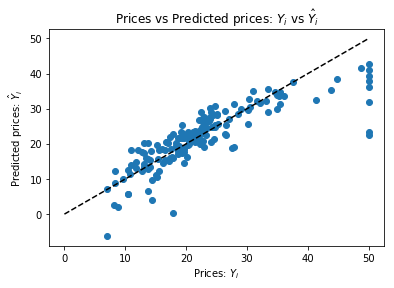

In [30]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)

## Run Stochastic Gradient Descent From Scikit-learn

Coefficients: 
 [  1.18075581e+12   3.87575188e+11   4.30378320e+11  -1.13167595e+10
  -4.44052119e+09  -1.10713829e+11   6.88911002e+11  -2.10551281e+09
  -4.79152839e+11  -4.78221266e+11  -1.65921774e+11  -1.62856360e+12
  -7.53318187e+10]
Mean squared error (train): 547701399479894639206264209408.00
Mean squared error (test): 535957263602554720817346772992.00


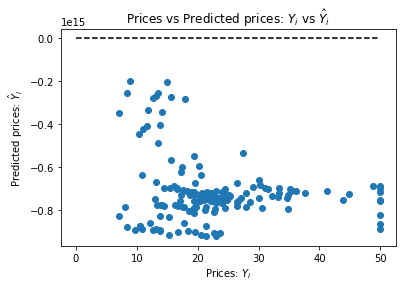

In [31]:
regr = linear_model.SGDRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)

## Run Linear Regression With Gradient Descent

Theta: 
 [ 0.04118205  0.75838013  0.5819058   0.37609294  0.9116603   0.52699451
  0.83073645  0.80325517  0.24207951  0.41618225  0.83207146  0.80353146
  0.20114089]
Mean squared error (train): 291269.872408
Mean squared error (test): 292796.730525


Time taken: 23.242653999999995
Theta: 
 [-0.13748847  0.07721751 -0.00253892  0.40790334  0.96017697  1.7464835
  0.08075044  0.2105049   0.19514893 -0.00756639  0.27772281  0.02570621
 -0.72059385]
Mean squared error (train): 34.4894885441
Mean squared error (test): 42.5554774409


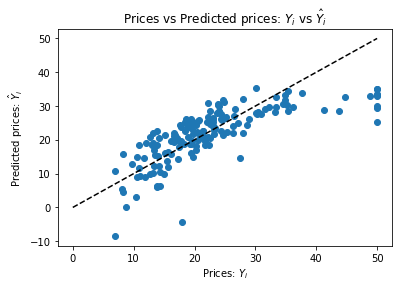

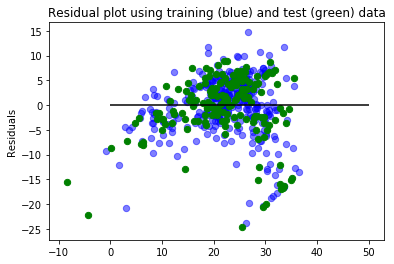

In [32]:
debug = False
num_of_iterations = 100000
alpha = 0.000004 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent(all_gen(X_train, y_train), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

## Run Linear Regression With Stochastic Gradient Descent

Theta: 
 [ 0.82690989  0.27745453  0.12272918  0.233533    0.09082901  0.52622667
  0.71987626  0.20221783  0.64180899  0.15896025  0.49695515  0.04404081
  0.54449782]
Mean squared error (train): 22521.1796943
Mean squared error (test): 23637.2724884


Time taken: 9.054838000000004
Theta: 
 [-0.14375813  0.08062003 -0.03283937  0.28195626  0.16282346  2.26065397
  0.06482335 -0.19251259  0.17412702 -0.01253289  0.2660948   0.02373716
 -0.67454645]
Mean squared error (train): 39.4126795742
Mean squared error (test): 51.2004035746


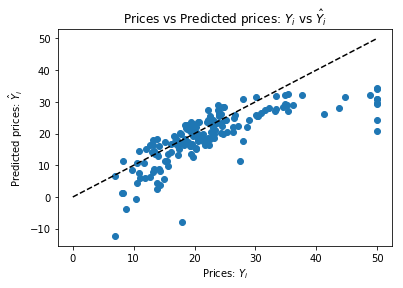

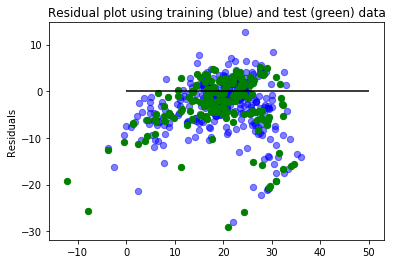

In [33]:
debug = False
num_of_iterations = 3000
alpha = 0.000007 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_stochastic(all_gen(X_train, y_train), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)


## Run Linear Regression With Mini Batch Gradient Descent

Theta: 
 [ 0.51367021  0.45807278  0.83925429  0.81724747  0.35079918  0.57019003
  0.97649915  0.60142495  0.96075909  0.42168125  0.92362327  0.02606461
  0.96247697]
Mean squared error (train): 92088.9172019
Mean squared error (test): 96843.0760277


Time taken: 15.485052999999994
Theta: 
 [-0.14647479  0.06428096 -0.03690006  0.86830638  0.48020168  3.67614384
  0.02856655 -0.47278609  0.19025806 -0.0055455  -0.02702505  0.02177209
 -0.5594051 ]
Mean squared error (train): 26.1681827345
Mean squared error (test): 33.7567456288


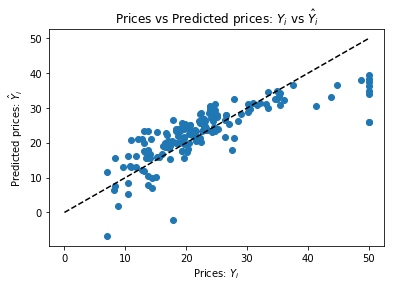

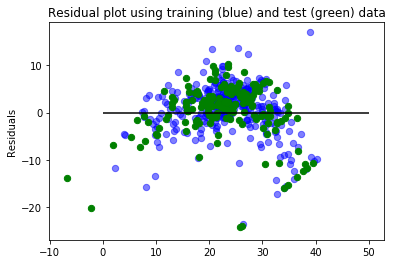

In [34]:
debug = False
num_of_iterations = 5000
alpha = 0.00001 # learning rate
batch_size = 50

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_stochastic(batch_gen(X_train, y_train, batch_size), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

# Next steps

- Adding cost curves for a train/test data set
- Find which features are most important
- Incorporate a stopping condition
- Reduce dimensions

# Resources

- Variants of gradient descent: http://ruder.io/optimizing-gradient-descent/
- Optimisation by grid exhaustive search: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html (this is *often* used to *jointly* select the best parameters of a model, i.e. the best learning rate, number of steps, learning rate decay, ...)